In [1]:
import cv2 
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from efficientnet.tfkeras import EfficientNetB0
from keras.models import load_model
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator 

In [2]:
path = os.getcwd()
main_dir =os.path.dirname(path) + "\\"
model_dir = main_dir + "models\\"
main_dir

'C:\\python_projects\\facebook_cv_proj\\'

In [3]:
class_names_dict = {'HDD-Post-Destruction':0, 'HDD-Pre-Destruction':1, 'SSD-Post-Destruction':2, 'SSD-Pre-Destruction':3}
def predict_classname(class_names):
    predict_class=''
    if class_names==0:
        predict_class='HDD-Post-Destruction'
    elif class_names==1:
        predict_class='HDD-Pre-Destruction'
    elif class_names==2:
        predict_class='SSD-Post-Destruction'
    else:
        predict_class='SSD-Pre-Destruction'   
    return  predict_class 

In [4]:
print('loading model.......')
ssd_hdd_model = tf.keras.models.load_model(model_dir + "4class_chennai_inception_set2_hybrid.h5") 
pre_post_hdd_model = tf.keras.models.load_model(model_dir + "pre_post_hdd_model_16.h5") 

loading model.......


In [6]:
test_dir = main_dir + "data\\ssd_hdd_image\\test"# "data\\test_image"

test_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_generator = test_datagen.flow_from_directory(test_dir, batch_size = 5, shuffle=False, class_mode = 'categorical', target_size = (224, 224))

Found 480 images belonging to 4 classes.


In [7]:
pred_ssd_hdd = ssd_hdd_model.predict(test_generator, workers=6)
pred_post_pre = pre_post_hdd_model.predict(test_generator, workers=6)

In [8]:
ensemble_pred = pred_ssd_hdd.copy()
hdd_ind = pred_ssd_hdd.argmax(axis=1) < 2
ensemble_pred[hdd_ind,:2] = pred_post_pre[hdd_ind,:]
'''this is for normalization of probs'''
print(ensemble_pred[hdd_ind,:].sum(axis=1))
ensemble_pred[hdd_ind,:] = np.divide(ensemble_pred[hdd_ind,:], ensemble_pred[hdd_ind,:].sum(axis=1)[:,None])
ensemble_pred[hdd_ind,:].sum(axis=1)

[1.         0.99999994 1.         1.0000004  1.0000001  0.99999994
 0.99999994 1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.         0.99999994 1.0000001
 1.         0.99999994 1.         0.99999994 1.         1.
 0.99999994 1.         1.0000002  1.         0.99999994 1.
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         0.99999994 1.
 1.         1.0000001  1.0000001  1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.
 1.         1.0000001  1.         1.         1.         1.
 1.         1.0000002  1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.0000001  1.         1.         1.         0.99999994 1.
 1.         1.   

array([1.        , 1.        , 1.        , 0.99999994, 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [9]:
max_probs = ensemble_pred.max(axis=1)
y_pred =  np.argmax(ensemble_pred, axis=1)
y_true = test_generator.classes
file_paths = test_generator.filepaths
data = zip(file_paths, ensemble_pred, max_probs, y_pred, y_true)

In [10]:
#cv2.destroyAllWindows()
os.chdir(main_dir)
df = pd.DataFrame(data, columns=['filename', 'result','max_probability','predict_class','actual_class'])
df.to_csv(main_dir+'\\output\\result_ensemble.csv') 

In [11]:
tp = len(df.loc[df.predict_class == df.actual_class])
fn = len(df.loc[df.predict_class != df.actual_class])
accuracy = tp / (tp+fn) * 100
accuracy, tp, fn

(99.58333333333333, 478, 2)

In [12]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

[[119   1   0   0]
 [  0 120   0   0]
 [  0   0 120   0]
 [  0   0   1 119]]


In [13]:
cf_matrix.flatten()

array([119,   1,   0,   0,   0, 120,   0,   0,   0,   0, 120,   0,   0,
         0,   1, 119], dtype=int64)

In [14]:
class_names = class_names_dict.keys()#[‘True Neg’,’False Pos’,’False Neg’,’True Pos’]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
percentages = np.divide(cf_matrix, np.sum(cf_matrix, axis=1)[:None])
group_percentages = ["{0:.2%}".format(value) for value in percentages.flatten()]
n_class = len(class_names)
type(cf_matrix)

numpy.ndarray

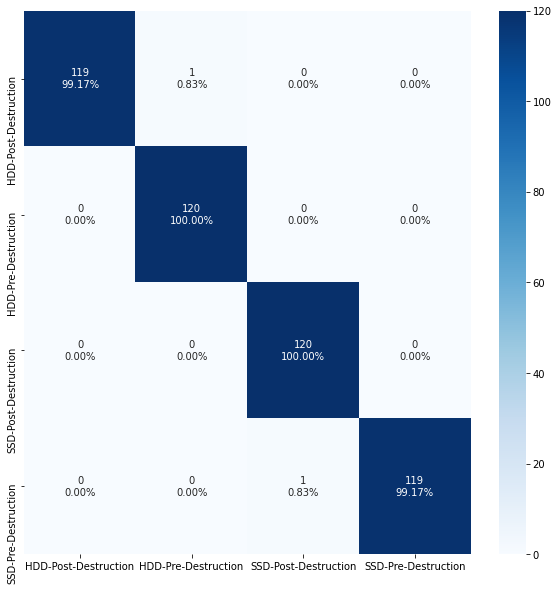

In [15]:
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(n_class,n_class)
plt.figure(figsize = (10,10))
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', yticklabels=class_names, xticklabels=class_names)
plt.savefig(main_dir + "//output//cf_matrix_ensemble.png")

In [16]:
cf_matrix.shape, labels.shape

((4, 4), (4, 4))